In [1]:
import collections
import matplotlib
import uproot
import sys
import site
import glob
import re
import math
sys.path.insert(0, site.getusersitepackages())

import numpy             as np
import awkward           as ak
import matplotlib.pyplot as plt
import pandas            as pd

# Wider Cells
from IPython.display                 import display, HTML, Markdown
from tqdm.notebook                   import tqdm
from matplotlib.backends.backend_pdf import PdfPages
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>div.output_scroll { height: 44em; }</style>"))

In [12]:
# Función para extraer el número después de "P"
def extract_p_number(filename):
    match = re.search(r"P(\d+)", filename)
    if match:
        return int(match.group(1))
    return -1  # Devuelve un valor pequeño si no se encuentra "P"

In [115]:
run = 1444
run_files = glob.glob(f"/eos/experiment/wcte/data/2025_commissioning/offline_data/{run}/WCTE_offline_R{run}S*P*.root")
#/eos/experiment/wcte/data/2025_commissioning/"+str(run)+"/*.root

# Ordenar los archivos usando extract_p_number
run_files = sorted(run_files, key=extract_p_number)
len(run_files)

324

In [14]:
# def read_all_parts():
#     tree = uproot.open(files[0])
#     keys = tree.keys()
#     print(keys)

#     branch = tree[keys[0]]
#     primal_event_numbers = [branch['event_number'].array().to_numpy()]
#     primal_window_times  = [branch['window_time'].array().to_numpy()]

#     for f in tqdm(files[1:]):
#         tree2 = uproot.open(f)
#         keys2 = tree2.keys()
#         for key2 in keys2:
#             branch2 = tree2[key2]
#             events = branch2['event_number'].array().to_numpy()
#             if len(events) != 0:
#                 primal_event_numbers.append(branch2['event_number'].array().to_numpy()+primal_event_numbers[-1].max()+1)
#                 primal_window_times.append(branch2['window_time'].array().to_numpy()+primal_window_times[-1].max()+1)   

# Select The Part File You Want To Use

# Select Only Those Events With The Same Number Of Waveforms And Hits

# For Those Good Events, Select Only Hits In Card 130 and Corresponding Channels And Etc

In [116]:
def selectec_good_events(part_file):
    tree = uproot.open(run_files[part_file]+":WCTEReadoutWindows")
    nevents = len(tree["hit_mpmt_card_ids"].array())

    file_hit_card_ids    = tree["hit_mpmt_card_ids"].array()
    file_hit_channel_ids = tree["hit_pmt_channel_ids"].array()
    file_hit_charges     = tree["hit_pmt_charges"].array()
    file_hit_times       = tree["hit_pmt_times"].array()

    file_waveform_card_ids = tree["pmt_waveform_mpmt_card_ids"].array()

    good_events = []

    for ievt in range(nevents):
        numHits = len(file_hit_card_ids[ievt])
        numWave = len(file_waveform_card_ids[ievt])
        if numHits == numWave and numHits != 0:
            good_events.append(ievt)


    return good_events, file_hit_card_ids, file_hit_channel_ids, file_hit_charges, file_hit_times, file_waveform_card_ids

In [16]:
def select_charges_for_beam_monitor(good_events, files, card, channels, plot_control=False, variable="charge"):
    
    file_hit_charges_masked_LChannel = []
    file_hit_charges_masked_RChannel = []

    for ievt in good_events:
        event_hit_card_ids    = files[0][ievt]
        event_hit_channel_ids = files[1][ievt]
        event_hit_charges     = files[2][ievt]
        event_hit_times       = files[3][ievt]

        event_waveform_card_ids = files[4][ievt]

        try:
            len(event_hit_card_ids) == len(event_waveform_card_ids)

        except:
            raise ValueError("This is not a good event, we havae different amount of hits and waveforms!")

        if plot_control:
            # Control Plot: Should Be The Exact Same
            plt.hist(event_hit_card_ids, bins=50, alpha=0.4);
            plt.hist(event_waveform_card_ids, bins=50, alpha=0.4);
            plt.title("Card IDs From Hits and From Waveforms");
            plt.xlabel("Card ID");

        # Create mask to card 130
        # Create mask to channels 7&8 which correspond to ACT3L-R
        # Combine masks
        # Apply masks to event_hit_charges to get the charge in those specific channels for that specific card
        mask_card = event_hit_card_ids == card
        mask_channel_L = (event_hit_channel_ids == channels[0])
        mask_channel_R = (event_hit_channel_ids == channels[1])
        combined_mask_L = mask_card & mask_channel_L
        combined_mask_R = mask_card & mask_channel_R

        if variable == "charge":
            file_hit_charges_masked_LChannel.append(event_hit_charges[combined_mask_L])
            file_hit_charges_masked_RChannel.append(event_hit_charges[combined_mask_R])

        elif variable == "time":
            file_hit_charges_masked_LChannel.append(event_hit_times[combined_mask_L])
            file_hit_charges_masked_RChannel.append(event_hit_times[combined_mask_R])

    file_hit_charges_masked_LChannel = ak.flatten(file_hit_charges_masked_LChannel)
    file_hit_charges_masked_RChannel = ak.flatten(file_hit_charges_masked_RChannel)

    return file_hit_charges_masked_LChannel, file_hit_charges_masked_RChannel

In [117]:
part = 1
good_events, *files = selectec_good_events(part)

# ACT3 and ACT4
file_hit_charges_ACT3L, file_hit_charges_ACT3R = select_charges_for_beam_monitor(good_events, files, 130, [7,8], False)
file_hit_charges_ACT4L, file_hit_charges_ACT4R = select_charges_for_beam_monitor(good_events, files, 130, [9,10], False)

# T1
file_hit_charges_T10L, file_hit_charges_T10R = select_charges_for_beam_monitor(good_events, files, 130, [13,14], False, "time")
file_hit_charges_T11L, file_hit_charges_T11R = select_charges_for_beam_monitor(good_events, files, 130, [15,16], False, "time")

# T0
file_hit_charges_T00L, file_hit_charges_T00R = select_charges_for_beam_monitor(good_events, files, 131, [12,13], False, "time")
file_hit_charges_T01L, file_hit_charges_T01R = select_charges_for_beam_monitor(good_events, files, 131, [14,15], False, "time")

In [118]:
# print("ACT3")
# print(len(file_hit_charges_ACT3L))
# print(f"{len(file_hit_charges_ACT3R)}\n")

# print("ACT4")
# print(len(file_hit_charges_ACT4L))
# print(f"{len(file_hit_charges_ACT4R)}\n")

# print("T1-0")
# print(len(file_hit_charges_T10L))
# print(len(file_hit_charges_T10R))
# print("T1-1")
# print(len(file_hit_charges_T11L))
# print(f"{len(file_hit_charges_T11R)}\n")

# print("T0-0")
# print(len(file_hit_charges_T00L))
# print(len(file_hit_charges_T00R))
# print("T0-1")
# print(len(file_hit_charges_T01L))
# print(f"{len(file_hit_charges_T01R)}\n")

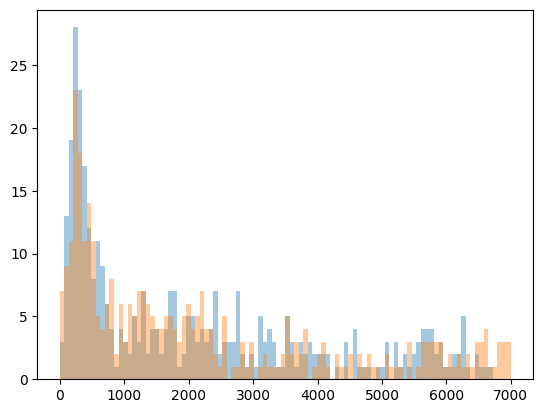

In [9]:
plt.hist(file_hit_charges_ACT4L, bins=100, alpha=0.4, range=(0, 7000));
plt.hist(file_hit_charges_ACT4R, bins=100, alpha=0.4, range=(0, 7000));

In [119]:
ACT3L_charge = []
ACT3R_charge = []

for part in tqdm(range(len(run_files)), total=len(run_files)):
    good_events, *files = selectec_good_events(part)

    if len(good_events) > 0:

        event      = good_events
        card_id    = files[0]
        channel_id = files[1]
        charge     = files[2]
        time       = files[3]

        data = [(ievt, icard, ichan, ichar, itime) for ievt, icard, ichan, ichar, itime in zip(event, card_id, channel_id, charge, time)]

        df = pd.DataFrame(data, columns=['event_id', "A", "B", "C", "D"])

        df = df.explode(list('ABCD'))

        df = df.rename(columns={"A": "card_id", "B": "channel_id", "C": "charge", "D": "time"})

        # Paso 1: Filtra por card 130 y canales 7 y 8
        filtered = df[(df["card_id"] == 130) & (df["channel_id"].isin([7, 8]))]

        # Paso 2: Cuenta cuántos hits hay por evento y canal
        counts = (
            filtered.groupby(["event_id", "channel_id"])
            .size()
            .unstack(fill_value=0)  # Esto crea columnas 7 y 8
        )

        # Paso 3: Quédate solo con eventos donde los hits en 7 y 8 son iguales
        valid_events = counts[counts.get(7, 0) == counts.get(8, 0)].index

        # Paso 4: Filtra el dataframe original
        result = filtered[filtered["event_id"].isin(valid_events)]

        ACT3L_charge.append(result[result["channel_id"].values == 7]["charge"].values)
        ACT3R_charge.append(result[result["channel_id"].values == 8]["charge"].values)


  0%|          | 0/324 [00:00<?, ?it/s]

In [122]:
ACT3L_charge = ak.flatten(ACT3L_charge)
ACT3R_charge = ak.flatten(ACT3R_charge)

In [123]:
ACT3L_charge = np.asarray(ACT3L_charge)
ACT3R_charge = np.asarray(ACT3R_charge)

In [124]:
print(len(ACT3L_charge))
print(len(ACT3R_charge))

37720
37720


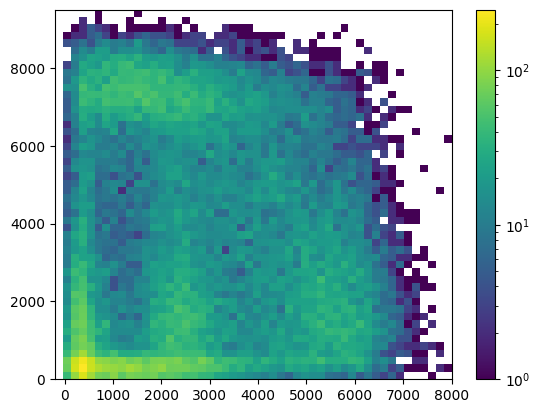

In [127]:
h = plt.hist2d(ACT3L_charge, ACT3R_charge, bins=(50, 50), norm="log", range=((-200, 8000), (0, 9500)));
plt.colorbar(h[3]);